In [94]:
%load_ext autoreload
%autoreload 2
import logging
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from dnafiber.inference import _get_model
import math
import time
from dnafiber.postprocess.core import Fibers
import cv2
import pandas as pd
from dnafiber.postprocess.error_detection import load_model
from dnafiber.postprocess import refine_segmentation
from dnafiber.ui.inference import ui_inference_cacheless
from dnafiber.ui.utils import (
    get_image_cacheless,
)
from dnafiber.deployment import ENSEMBLE, Models

for name, l in logging.root.manager.loggerDict.items():
    if "streamlit" in name:
        l.disabled = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
reverse_channels = False
sint_file = Path(
    "/home/clement/Documents/data/DNAFiber/Input/YM-2025-20/2025-05-16/siNT-01.czi"
)

model = [_get_model(f).cuda() for f in ENSEMBLE]
detection_model = None
# model = [model1, model2]
all_results_blurred = []
all_images_blurred = []

for file in tqdm([sint_file], desc="Processing files"):
    image = get_image_cacheless(file, False)

    for sigma in np.linspace(0, 24, 5):
        ksize = int(2 * math.ceil(3 * sigma) + 1)
        print("Starting")
        gaussian_blurred = cv2.GaussianBlur(image, (ksize, ksize), sigma)
        print("Gaussian blurred applied")
        all_images_blurred.append(gaussian_blurred)
        start = time.time()
        prediction: Fibers = ui_inference_cacheless(
            _model=model,
            _image=gaussian_blurred,
            _device="cuda",
            use_tta=False,
            pixel_size=0.13,
            only_segmentation=False,
            use_correction=None,
            verbose=True,
        )
        df = prediction.to_df(img_name=file.stem, filter_invalid=False)
        df["Type"] = "-".join(file.stem.split("-")[:-1])
        df["sigma"] = sigma
        all_results_blurred.append(df)


Processing files:   0%|          | 0/1 [00:00<?, ?it/s]

Starting
Gaussian blurred applied


100%|██████████| 21/21 [00:01<00:00, 17.57it/s]


Segmentation done...
Starting
Gaussian blurred applied


100%|██████████| 21/21 [00:01<00:00, 17.59it/s]


Segmentation done...
Starting
Gaussian blurred applied


100%|██████████| 21/21 [00:01<00:00, 17.56it/s]


Segmentation done...
Starting
Gaussian blurred applied


100%|██████████| 21/21 [00:01<00:00, 17.50it/s]


Segmentation done...
Starting
Gaussian blurred applied


100%|██████████| 21/21 [00:01<00:00, 17.55it/s]


Segmentation done...


In [96]:
from skimage.util import random_noise

all_results_noise = []
all_images_noise = []
for file in tqdm([sint_file], desc="Processing files"):
    image = get_image_cacheless(file, False)
    for sigma in np.linspace(0, 1, 5):
        print("Starting")
        noisy = random_noise(image, mode="gaussian", var=sigma**2, clip=True) * 255
        print("Gaussian noise applied")
        noisy = noisy.astype(np.uint8)
        all_images_noise.append(noisy)
        start = time.time()
        prediction: Fibers = ui_inference_cacheless(
            _model=model,
            _image=noisy,
            _device="cuda",
            use_tta=False,
            pixel_size=0.13,
            only_segmentation=False,
            use_correction=None,
        )
        df = prediction.to_df(img_name=file.stem, filter_invalid=False)
        df["Type"] = "-".join(file.stem.split("-")[:-1])
        df["sigma"] = sigma
        all_results_noise.append(df)


Processing files:   0%|          | 0/1 [00:00<?, ?it/s]

Starting
Gaussian noise applied


100%|██████████| 21/21 [00:01<00:00, 17.53it/s]


Segmentation done...
Starting
Gaussian noise applied


100%|██████████| 21/21 [00:01<00:00, 17.56it/s]


Segmentation done...
Starting
Gaussian noise applied


100%|██████████| 21/21 [00:01<00:00, 17.53it/s]


Segmentation done...
Starting
Gaussian noise applied


100%|██████████| 21/21 [00:01<00:00, 17.49it/s]


Segmentation done...
Starting
Gaussian noise applied


100%|██████████| 21/21 [00:01<00:00, 17.49it/s]


Segmentation done...


/tmp/ipykernel_1298565/3298968069.py:37: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(
/tmp/ipykernel_1298565/3298968069.py:45: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 46.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 42.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 42.9% of the points cannot be 

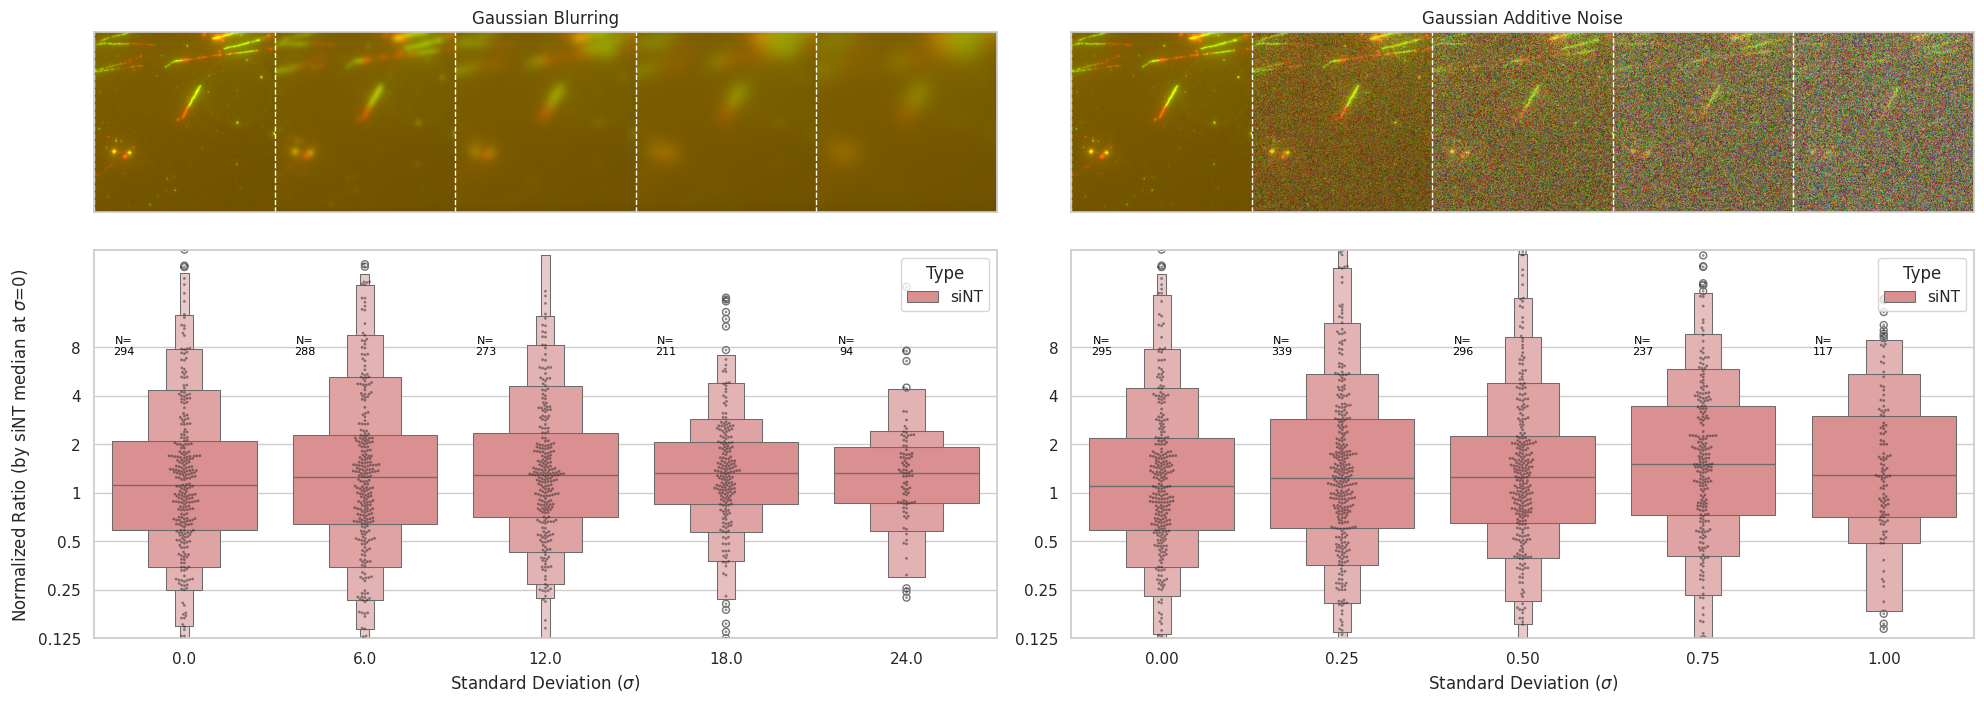

In [99]:
from dnafiber.analysis.ratios import (
    create_boxen_plot,
    normalize_df,
    graders_statistical_test,
    compare_pairs,
    create_swarm_plot,
    select_N_closest_to_mean,
)


df_blurred = pd.concat(all_results_blurred, ignore_index=True)
df_blurred["sigma"] = df_blurred["sigma"].astype(str)
df_blurred["Ratio"] = df_blurred["Ratio"].astype(float)
df_noise = pd.concat(all_results_noise, ignore_index=True)
df_noise["sigma"] = df_noise["sigma"]
df_noise["Ratio"] = df_noise["Ratio"].astype(float)


order = ["siNT"]
df_blurred["Type"] = pd.Categorical(df_blurred["Type"], categories=order, ordered=True)
df_noise["Type"] = pd.Categorical(df_noise["Type"], categories=order, ordered=True)
df_noise["Type"]

df_noise = df_noise[df_noise["Valid"]]
df_blurred = df_blurred[df_blurred["Valid"]]

df_noise["Grader"] = "AI"
df_blurred["Grader"] = "AI"
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(20, 8), sharey=False)

palette = ["#e78284", "#81c8be", "#8caaee"]
for i, (ax, df, title) in enumerate(
    zip(axes[1, :], [df_blurred, df_noise], ["Gaussian Blurring", "Gaussian Noise"])
):
    sns.boxenplot(
        x="sigma",
        y="Ratio",
        hue="Type",
        data=df,
        ax=ax,
        palette=palette,
    )
    sns.swarmplot(
        x="sigma",
        y="Ratio",
        hue="Type",
        data=df,
        ax=ax,
        color="black",
        alpha=0.5,
        legend=None,
        s=2,
    )
    if i == 0:
        ax.set_ylabel(r"Normalized Ratio (by siNT median at $\sigma$=0)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel(r"Standard Deviation ($\sigma$)")
    ax.set_yscale("log")
    ax.set_yticks([0.125, 0.25, 0.5, 1, 2, 4, 8], [0.125, 0.25, 0.5, 1, 2, 4, 8])
    ax.set_ylim(0.125, 32)
    ax.minorticks_off()
    ax.legend(title="Type", loc="upper right", ncol=3)
    if title == "Gaussian Noise":
        ax.set_xticklabels([f"{sigma:.2f}" for sigma in df["sigma"].unique()])

    # Add text to indicate the number of fibers per sigma and type
    for i, sigma in enumerate(df["sigma"].unique()):
        for j, fiber_type in enumerate(df["Type"].unique()):
            count = df[(df["sigma"] == sigma) & (df["Type"] == fiber_type)].shape[0]
            ax.text(
                i + j / 3.5 - 1 / 3,
                7,
                f"N=\n{count}",
                ha="center",
                va="bottom",
                fontsize=8,
                color="black",
            )

start = 4900
length = 512
subset_indices_y = slice(start + 200, start + 200 + length)
subset_indices_x = slice(start, start + length)
for i, (ax, df, title) in enumerate(
    zip(
        axes[0, :],
        [df_blurred, df_noise],
        ["Gaussian Blurring", "Gaussian Additive Noise"],
    )
):
    sigmas = df["sigma"].unique()
    current_list = all_images_blurred if i == 0 else all_images_noise

    ax.set_ylim(0, 1)
    ax.set_xlim(0, len(sigmas))
    ax.set_yscale("linear")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

    for j, s in enumerate(sigmas):
        img1 = current_list[j][subset_indices_y, subset_indices_x]
        ax.imshow(img1, extent=[j, j + 1, 0, 1])
        ax.axvline(j, color="white", linestyle="--", linewidth=1)


# Reduce the margin between the subplots
plt.subplots_adjust(hspace=0.0, wspace=0.2)
plt.tight_layout()
plt.savefig(f"noise_robustness_ensemble.png", dpi=300, bbox_inches="tight")
df_noise.to_csv("df_noise_ensemble.csv", index=False)
df_blurred.to_csv("df_blurred_ensemble.csv", index=False)
plt.show()


/tmp/ipykernel_1298565/533848488.py:24: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(


/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 34.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 35.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 43.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/

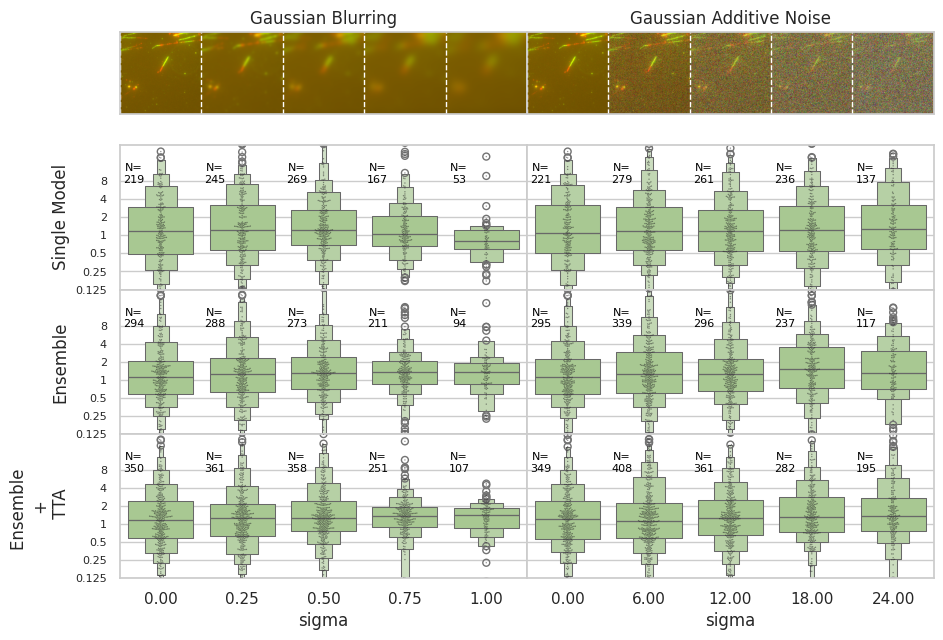

In [106]:
data_files = [
    ("df_blurred_unet_mobileones3.csv", "df_noise_unet_mobileones3.csv"),
    ("df_blurred_ensemble.csv", "df_noise_ensemble.csv"),
    ("df_blurred_ensemble_TTA.csv", "df_noise_ensemble_TTA.csv"),
]
names = ("Single Model", "Ensemble", "Ensemble \n+\n TTA")
sns.set_theme(style="whitegrid")
scale = 0.75
fig, axes = plt.subplots(4, 2, figsize=(14 * scale, 10 * scale))

for current_f, (path_blurred, path_noise) in enumerate(data_files):
    df_blurred = pd.read_csv(path_blurred)
    df_noise = pd.read_csv(path_noise)

    sns.boxenplot(
        x="sigma",
        y="Ratio",
        hue="Type",
        data=df_blurred,
        ax=axes[current_f + 1, 0],
        palette=["#a6d189"],
        legend=None,
    )
    sns.swarmplot(
        x="sigma",
        y="Ratio",
        hue="Type",
        data=df_blurred,
        ax=axes[current_f + 1, 0],
        color="black",
        alpha=0.5,
        legend=None,
        s=1,
    )

    sns.boxenplot(
        x="sigma",
        y="Ratio",
        hue="Type",
        data=df_noise,
        ax=axes[current_f + 1, 1],
        palette=["#a6d189"],
        legend=None,
    )
    sns.swarmplot(
        x="sigma",
        y="Ratio",
        hue="Type",
        data=df_noise,
        ax=axes[current_f + 1, 1],
        color="black",
        alpha=0.5,
        legend=None,
        s=1,
    )
    dfs = (df_blurred, df_noise)
    current_axes = axes[current_f + 1, :]
    for j, ax in enumerate(current_axes):
        if current_f == 2:
            ax.set_xticklabels([f"{sigma:.2f}" for sigma in df["sigma"].unique()])
        else:
            ax.set_xticklabels([])
            ax.set_xlabel("")

        ax.set_yscale("log")
        ax.set_yticks([0.125, 0.25, 0.5, 1, 2, 4, 8], [0.125, 0.25, 0.5, 1, 2, 4, 8])
        ax.set_ylim(0.125, 32)
        if j == 1:
            ax.set_yticklabels([])
            ax.set_ylabel("")
        else:
            # Reduce font size for y ticks
            ax.tick_params(axis="y", which="major", labelsize=8)
            ax.set_ylabel(f"{names[current_f]}")

        df = dfs[j]
        # Add text to indicate the number of fibers per sigma and type
        for i, sigma in enumerate(df["sigma"].unique()):
            count = df[(df["sigma"] == sigma)].shape[0]
            ax.text(
                i - 1 / 3,
                7,
                f"N=\n{count}",
                ha="center",
                va="bottom",
                fontsize=8,
                color="black",
            )


start = 4900
length = 512
subset_indices_y = slice(start + 200, start + 200 + length)
subset_indices_x = slice(start, start + length)
for i, (ax, df, title) in enumerate(
    zip(
        axes[0, :],
        [df_blurred, df_noise],
        ["Gaussian Blurring", "Gaussian Additive Noise"],
    )
):
    sigmas = df["sigma"].unique()
    current_list = all_images_blurred if i == 0 else all_images_noise

    ax.set_ylim(0, 1)
    ax.set_xlim(0, len(sigmas))
    ax.set_yscale("linear")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

    for j, s in enumerate(sigmas):
        img1 = current_list[j][subset_indices_y, subset_indices_x]
        ax.imshow(img1, extent=[j, j + 1, 0, 1])
        ax.axvline(j, color="white", linestyle="--", linewidth=1)


# Reduce the margin between the subplots
plt.subplots_adjust(hspace=0.0, wspace=0)
plt.savefig(f"noise_robustness_comparison.png", dpi=300, bbox_inches="tight")